**Setup iniziale**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')
cwd= 'drive/MyDrive/Colab Notebooks'
file_path= cwd + '/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Carichiamo il dataset
# -> nrows indica il numero di righe massimo da caricare (qua ne carichiamo 250.000 per cercare di avere nel dataframe almeno 5 possibili classi di 'status')
# -> na_values contiene le stringhe del file che indicano valori assenti nelle celle (Pandas li sostituisce con un valore None)
df= pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA','ND', 'n/a', ''], nrows=250000)

# LA COLONNA (o feature) 'status' È IL TARGET DA PREDIRE (ovvero la nostra Y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data cleaning**

In [ ]:
# Puliamo il dataframe
# La funzione dropna() usa questi parametri:
# -> "axis" indica: 0=righe / 1=colonne
# -> "how" indica: 'all'="se tutti i valori sono nulli" / 'any'="se almeno un valore è nullo"
# -> "subset" indica di considerare solo i valori di certe colonne quando deve verificare se sono nulli
# -> "inplace=True" dice a Pandas di fare la modifica direttamente sull'oggetto (quindi le funzioni ritorneranno None)
df.dropna(axis=1, how='all', inplace=True) # Eliminiamo tutte le colonne che hanno tutti valori None (SOLO VALORI NULLI)
df.dropna(axis=0, how='any', subset='status', inplace=True) # Eliminiamo tutte le righe che hanno un valore None nel campo 'status' (perché non sono classificabili)

**Pre-processing**

* Bilanciamo le classi della feature target (alcune potrebbero essere poco rappresentate: meglio unirle).
* Facciamo split del dataset per training e test.
* Facciamo scaling.

In [ ]:
# Convertiamo i valori della colonna 'date' in datetime
df['date']= pd.to_datetime(df['date'], errors='coerce')
# Estraiamo il valore dell'anno da ogni datetime e lo mettiamo in una nuova colonna 'year' che creiamo appositamente
df['year']= df['date'].dt.year

In [ ]:
# Visualizziamo il numero di righe per ogni classe della feature 'status', ovvero quante righe abbiamo per:
# 'Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous' (non presente nel dataframe)
# "dropna=False" dice a Pandas di contare anche le righe che hanno valori None in qualche campo (di default è True)
print("\nValori per ogni classe di 'status':")
print(df['status'].value_counts(dropna=False))


Valori per ogni classe di 'status':
status
Good                              203730
Moderate                           42395
Unhealthy for Sensitive Groups      3174
Unhealthy                            251
Very Unhealthy                         3
Name: count, dtype: int64


Notiamo che la classe 'Hazardous' è del tutto assente nel dataframe e che le classi 'Unhealthy' e 'Very Unhealty' sono molto poco rappresentate, quindi le possiamo unire in una sola classe che chiamiamo 'Poor'.

In [ ]:
# Rimpiazziamo i valori 'Hazardous', 'Very Unhealty' e 'Unhealthy' nella colonna 'status' con il valore 'Poor'
df['status'] = df['status'].replace({
    "Hazardous": "Poor",
    "Very Unhealthy": "Poor",
    "Unhealthy": "Poor"
})

# Rifacciamo il conteggio del numero di righe per ogni classe della feature 'status' con i nomi delle classi modificati, ovvero:
# 'Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Poor'
print("\nValori per ogni classe di 'status':")
print(df['status'].value_counts(dropna=False))


Valori per ogni classe di 'status':
status
Good                              203730
Moderate                           42395
Unhealthy for Sensitive Groups      3174
Poor                                 254
Name: count, dtype: int64


In [ ]:
# Selezioniamo i nomi delle colonne che ci interessano per l'addestramento del modello (ovvero le nostre X)
features_names= [
    'pm2.5', 'pm10',
    'co', 'co_8hr',
    'no2', 'nox', 'no',
    'so2',
    'o3',
    'windspeed', 'winddirec',
    'year', 'longitude', 'latitude'
]
# Abbiamo rimosso pm2.5_avg, pm10_avg --> sono troppo correlate con la colonna target 'status' (target leakage), guardo matrice correlazione e tengo solo una di quelle correlate
#così non sovraccarico il mio modello di feature
X= df[features_names] # Selezioniamo le colonne che ci interessano per l'addestramento
Y= df['status'] # Selezioniamo la colonna target da predire

# Splittiamo:
# -> le righe presenti in X in: righe per l'addestramento (70%: X_train) + righe per il test (30%: X_test)
# -> le righe presenti in Y in: righe per l'addestramento (70%: Y_train) + righe per il test (30%: Y_test)
X_train, X_test, Y_train, Y_test= train_test_split(
    X, Y,
    test_size=0.3,   # 30% per il test e 70% per l'addestramento
    random_state=42  # Seme per cercare di ottenere ad ogni esecuzione un risultato simile (facoltativo)
)

# Mostriamo il numero di righe e colonne presenti in X_train ed in X_test
print("\nNumero di righe e colonne di X_train:", X_train.shape)
print("Numero di righe e colonne di X_test: ", X_test.shape)

# Facciamo lo scaling dei valori presenti in X_train ed in X_test
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)  # Fittiamo (fittare=fa media e dev standard) lo scaler sui valori di X_train e scaliamo i valori
X_test_scaled= scaler.transform(X_test)        # Facciamo la stessa cosa sui valori di X_test ma senza fittare di nuovo la scaler (non serve)


Numero di righe e colonne di X_train: (174687, 14)
Numero di righe e colonne di X_test:  (74866, 14)


**Model building e valutazione delle performance**

In [ ]:
# Inizializziamo il modello (random_state facoltativo)
model= DecisionTreeClassifier(random_state=42)
# Addestriamo il modello sui dati di train, ovvero:
# -> X_train (che però abbiamo scalato in X_train_scaled)
# -> Y_train  non uso trained perchè modello deve lavorare sulle classi non sui valori scalati (fare lo scaling server per le neurali/reg lin)(ovvero le classi corrispondenti alle righe di X_train: sono le soluzioni della predizione che il modello userà per capire di che classe è una riga)
model.fit(X_train_scaled, Y_train)

# Testiamo quanto è diventato bravo il modello facendogli predire a che classi corrispondono le righe di X_test (che abbiamo scalato in X_test_scaled)
Y_pred= model.predict(X_test_scaled) # Mettiamo i risultati di ogni predizione (una per ogni riga di X_test) in Y_pred

# Ora paragoniamo i valori predetti dal modello (ovvero Y_pred) con i valori reali (ovvero Y_test): in questo modo vediamo le sue performance (ovvero quanto è bravo)
print("\nPerformance del modello:")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred):.2f}") # La funzione accuracy_score() ci da la percentuale di predizioni corrette


Performance del modello:
Accuracy: 0.88


**Visualizzazione grafica dell'albero decisionale**

La funzione plot_tree() è dedicata a questo scopo. Viene usata insieme a Matplotlib.

Features usate per l'addestramento: ['pm2.5', 'pm10', 'co', 'co_8hr', 'no2', 'nox', 'no', 'so2', 'o3', 'windspeed', 'winddirec', 'year', 'longitude', 'latitude']


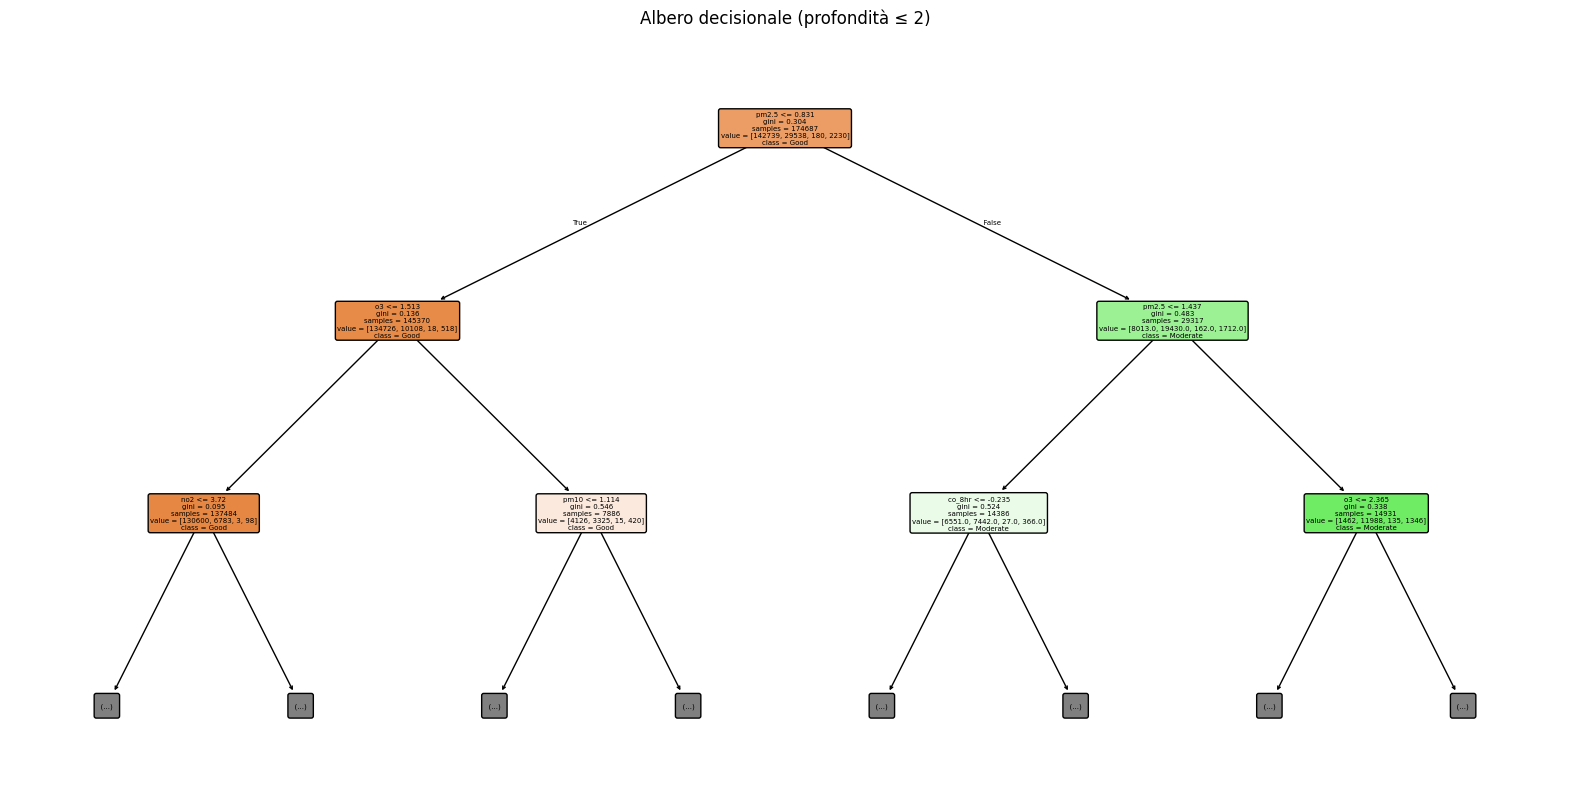

In [ ]:
print("Features usate per l'addestramento:", X.columns.tolist())

plt.figure(figsize=(20, 10)) # Dimensioni del disegno
plot_tree(
    model,
    max_depth=2, # Profondità massima da visualizzare
    feature_names=X.columns,
    class_names=[str(classe) for classe in sorted(Y.unique())],
    filled=True,  # Formattazione disegno
    rounded=True, # Formattazione disegno
    fontsize=5    # Formattazione disegno
)
plt.title("Albero decisionale (profondità ≤ 2)") # Titolo del disegno
plt.show()

**Visualizzazione della matrice di confusione**

Le funzioni:
* confusion_matrix()
* ConfusionMatrixDisplay()

sono dedicate a questo scopo. Anche esse vengono usate insieme a Matplotlib.

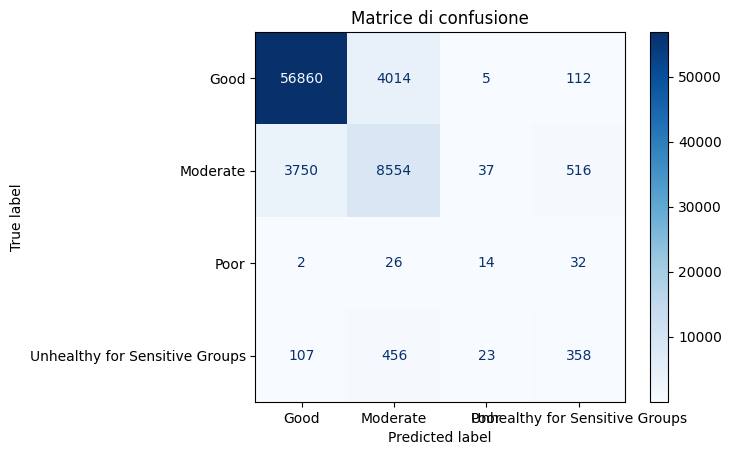

In [ ]:
cm= confusion_matrix(Y_test, Y_pred) # Confrontiamo le classi reali dei dati di test con le classi predette dal modello per creare la matrice di confusione
# Dobbiamo dire però alla funzione che visualizza la matrice di confusione come si chiamano le classi: lo facciamo nel parametro "display_labels" e gliele diciamo
# in ordine con la funzione sorted()
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(Y.unique()))
disp.plot(cmap='Blues') # Formattazione disegno
plt.title("Matrice di confusione") # Titolo disegno
plt.show()

Possiamo notare che il modello è molto bravo a predire la classe 'Good', le altre classi non molto.